new

In [12]:
from skimage.measure import label, regionprops 
from skimage.color import label2rgb

In [13]:

import numpy as np
import cv2
import torch

# Load the image
image = cv2.imread('../images/A-1.jpg', cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Load the mask
mask = np.load('output1_seg.npy', allow_pickle=True).item()
mask = mask['masks']
# Normalize the mask values to 0-255
mask_normalized = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# Create a red mask
red_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
red_mask[:, :, 2] = mask_normalized  # Set red channel


In [14]:
mask2 = np.load('output4_seg.npy', allow_pickle=True).item()
mask2 = mask2['masks']


In [15]:
# Convert the mask to float32 before normalization 
mask2_float32 = mask2.astype(np.float32)
# Normalize the second mask values to 0-255 
mask2_normalized = cv2.normalize(mask2_float32, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Create a blue mask 
blue_mask = np.zeros((mask2.shape[0], mask2.shape[1], 3), dtype=np.uint8) 
blue_mask[:, :, 0] = mask2_normalized # Set blue channel

In [16]:

# Check if CUDA is available and use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to Torch tensors
image_tensor = torch.from_numpy(image).to(device)
red_mask_tensor = torch.from_numpy(red_mask).to(device)
blue_mask_tensor = torch.from_numpy(blue_mask).to(device)

In [17]:
# Convert grayscale image to 3-channel image
image_3channel = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Convert to Torch tensor
image_3channel_tensor = torch.from_numpy(image_3channel).to(device)

In [18]:

# Overlay the mask
overlayed_image_tensor = torch.max(image_3channel_tensor, red_mask_tensor)
final_overlayed_image_tensor = torch.max(overlayed_image_tensor, blue_mask_tensor)

# Label each cluster 
labeled_clusters = label(mask2)

final_overlayed_image_tensor = final_overlayed_image_tensor.cpu().numpy()
final_overlayed_image_tensor = final_overlayed_image_tensor.astype(np.uint8)

In [20]:
# Add labels to the clusters 
for region in regionprops(labeled_clusters): 
    # Take the centroid of the region to place the label 
    centroid = region.centroid 
    cv2.putText(final_overlayed_image_tensor, str(region.label), (int(centroid[1]), int(centroid[0])), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 255, 255), 4, cv2.LINE_AA)

In [21]:
# Save the output image
cv2.imwrite('overlayed_image.jpg', final_overlayed_image_tensor)

print("Overlay completed and saved as overlayed_image.jpg")


Overlay completed and saved as overlayed_image.jpg


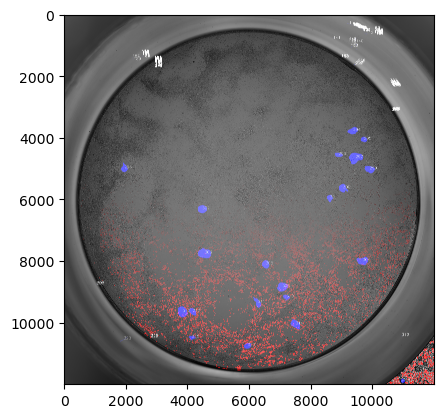

In [22]:
from cellpose import io
import matplotlib.pyplot as plt
img = io.imread('overlayed_image.jpg')
plt.imshow(img) 
plt.show()